In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
from scipy import signal
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
from XSpect.XSpect_Processor import Peaks
from XSpect.XSpect_Processor import Background
from matplotlib.patches import Patch
import pickle


## Viewing Static XES Spectra. Here essentially define runs you want to analyze, the detector you're interested in, and the energy axis you want. 

Processing: 100%|██████████| 9/9 [00:04<00:00,  1.82Shot_Batch/s]


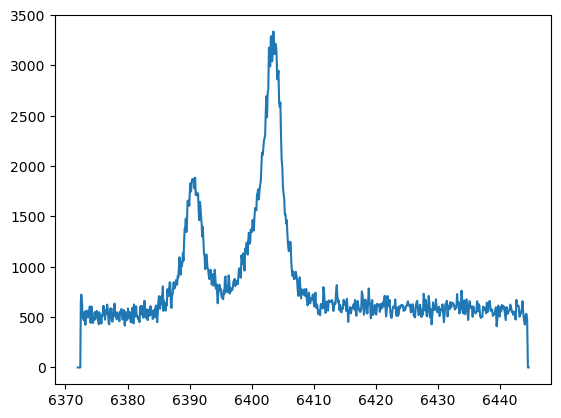

In [2]:
##do not change

xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1033223',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'

## end do not change

#Set epix detector here
xes.key_epix=['epix_1/ROI_0_area'] #Change epix_1 to epix_2 if desired.
xes.rois=[[48,61]] #set this ROI and iterate with the full detector image in the next cell.
#change ROI for new XES lines.

xes.hitfind=True

#remove this filter if measuring with attenuating beam e.g. with foil.
xes.add_filter('xray','ipm',1.0E3)
##

xes.adu_cutoff=3.0
xes.angle=2


xes.run_parser(['665-667']) 
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
#these values come from the crystal geometry. Change A to offset the energy to match real life. 
v.make_energy_axis(A=41.25, R=250,  mm_per_pixel=0.05, d=0.981)
#v.make_energy_axis(A=67.78, R=250,mm_per_pixel=0.05, d=0.859)

plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()



## View the detector image and verify the angle that we applied is good and the ROI is good. 

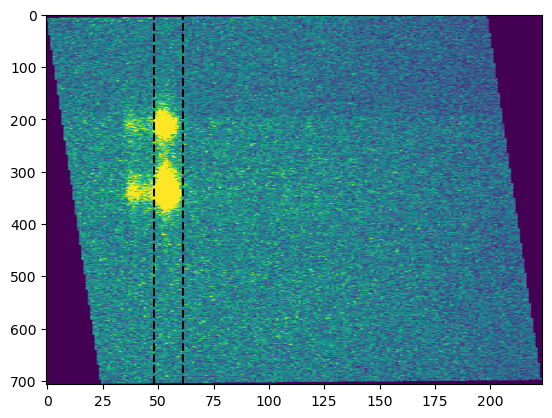

In [3]:
xes.analyzed_runs[0].epix
v.combine_static_spectra(xes_analysis=xes,xes_key='epix')
v.summed_xes.shape
vmin, vmax = np.percentile(v.summed_xes, [1,99])
plt.imshow(v.summed_xes,vmin = vmin, vmax = vmax, aspect='auto')
for i in xes.rois[0]:
    plt.axvline(i,color='k',linestyle='--')

## Here we fit the background polyomial and from that calcualte the FWHM of the Ka1 and First moment.
## Look at the plot and verify the pink exclusion zones are indeed excluding the spectral signal and any strange detector edge artifacts.
## The dashed lines indicate where the FWHM will be calculated.

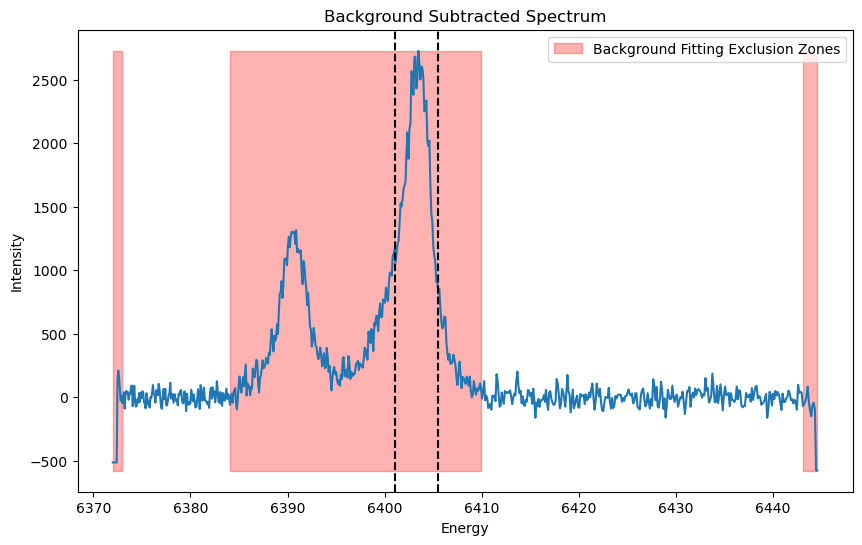

In [4]:
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
exclusions= (
    (6360, 6373), #edge of detector
    (6384, 6410),
    # (7457,7485), #Main peaks
    (6443,6450),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)

 
  
plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Background Fitting Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
fwhm_range=[6401.1,6405.5]
for i in fwhm_range:
    plt.axvline(i,color='k',linestyle='--')
#plt.xlim(6395,6410)
plt.show()
xes.first_moment=Peaks.first_moment(v.energy,v.background_subtracted,6398,6408)
xes.popt=Peaks.gaussian_fwhm(v.energy,v.background_subtracted,fwhm_range[0],fwhm_range[1],all_vals=True)
#print(xes.first_moment,xes.fwhm)


## Here we plot the fitted gaussian to verify it is somewhat reasonable with the spectrum. If it is not then modify fwhm_range in the previous cell.

(6395.0, 6410.0)

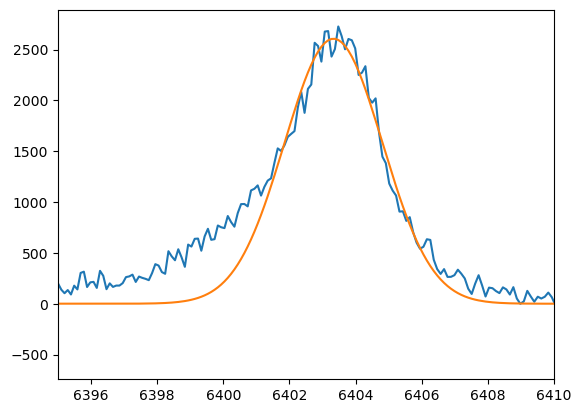

In [5]:
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.plot(v.energy, Peaks.gaussian(v.energy,*xes.popt))
plt.xlim(6395,6410)

## Here we perform the first moment and FWHM calculation on the normalized background subtracted data.

6402.891129764138 3.7120191764253496


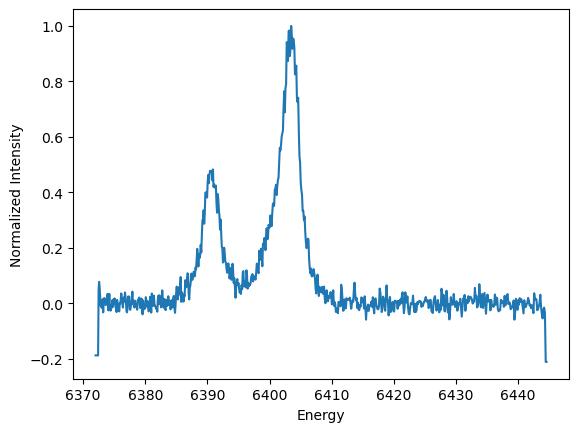

In [6]:
#First moment calculated after maximum peak normalized to 1
v.normalize_peak(6386,6418)
xes.first_moment=Peaks.first_moment(v.energy,v.normalized_peak,6398,6408)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.normalized_peak,6401,6405)
plt.plot(v.energy,v.normalized_peak)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
print(xes.first_moment,xes.fwhm)

Text(0, 0.5, 'Normalized Intensity')

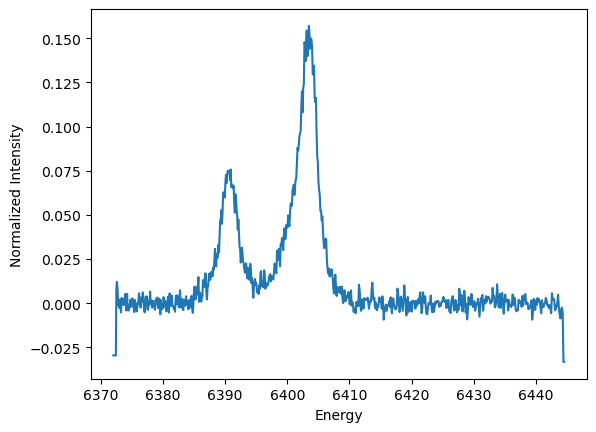

In [7]:
#Normalizes spectrum to make the area under in specified range equal to unity
v.normalize_spectrum(6386,6418)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

## Here we apply Savitzky-Golay smoothing to the normalized specta and dump the analyzed data and visualization steps (aggregation, normalization, etc) into .pkl files. Then the final "product" here is v.energy and v.smoothed.

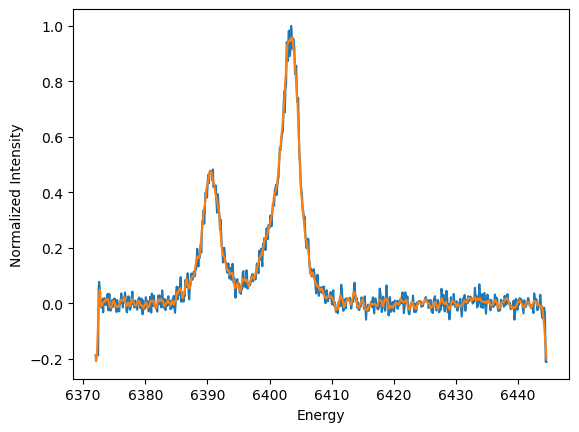

In [8]:
v.smoothed = signal.savgol_filter(v.normalized_peak, window_length=10, polyorder=2, mode="nearest")
plt.plot(v.energy,v.normalized_peak)
plt.plot(v.energy,v.smoothed)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

#Pickles data and analysis files based on above code
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

## Printing statistics here to verify that XES hit finding seems reasonable. It should be close to the crystal hit finding percents.

In [9]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()

First Moment: 6402.891129764138
FWHM: 3.7120191764253496
Run Number: 665
  Total: 4426
  X-ray Total: 4426
  Laser Total: 4426
  XES_Hits: 1303
  Percent_XES_Hits: 29.44%

Run Number: 666
  Total: 8996
  X-ray Total: 8996
  Laser Total: 8996
  XES_Hits: 5068
  Percent_XES_Hits: 56.34%

Run Number: 667
  Total: 1816
  X-ray Total: 1816
  Laser Total: 1816
  XES_Hits: 1232
  Percent_XES_Hits: 67.84%



# Manganese Analysis Below


Processing: 100%|██████████| 9/9 [00:06<00:00,  1.46Shot_Batch/s]


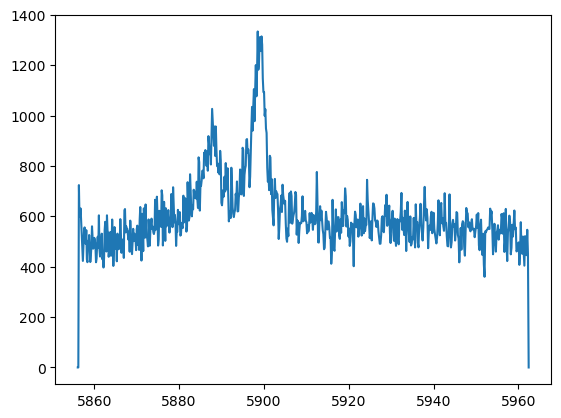

In [12]:
##do not change

xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1033223',lcls_run=23)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'

## end do not change

#Set epix detector here
xes.key_epix=['epix_2/ROI_0_area'] #Change epix_1 to epix_2 if desired.
xes.rois=[[52,69]] #set this ROI and iterate with the full detector image in the next cell.
#change ROI for new XES lines.

xes.hitfind=True

#remove this filter if measuring with attenuating beam e.g. with foil.
xes.add_filter('xray','ipm',1.0E3)
##

xes.adu_cutoff=3.0
xes.angle=0.5


xes.run_parser(['665-667']) 
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
#these values come from the crystal geometry. Change A to offset the energy to match real life. 
v.make_energy_axis(A=69.15, R=250,  mm_per_pixel=0.05, d=1.089)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()



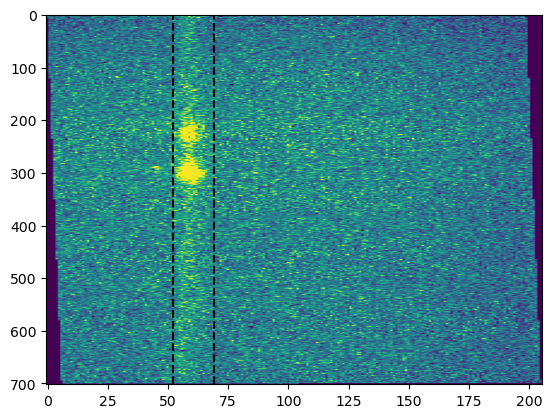

In [13]:
xes.analyzed_runs[0].epix
v.combine_static_spectra(xes_analysis=xes,xes_key='epix')
v.summed_xes.shape
vmin, vmax = np.percentile(v.summed_xes, [1,99])
plt.imshow(v.summed_xes,vmin = vmin, vmax = vmax, aspect='auto')
for i in xes.rois[0]:
    plt.axvline(i,color='k',linestyle='--')

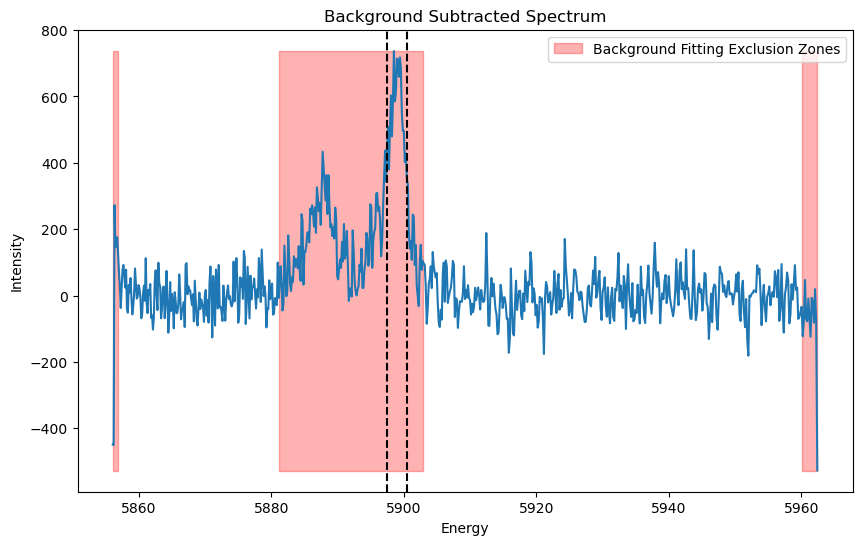

In [14]:
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
exclusions= (
    (5850, 5857), #edge of detector
    (5881, 5903),
    # (7457,7485), #Main peaks
    (5960,5965),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)

 
  
plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Background Fitting Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
fwhm_range=[5897.5,5900.5,]
for i in fwhm_range:
    plt.axvline(i,color='k',linestyle='--')
#plt.xlim(6395,6410)
plt.show()
xes.first_moment=Peaks.first_moment(v.energy,v.background_subtracted,fwhm_range[0],fwhm_range[1])
xes.popt=Peaks.gaussian_fwhm(v.energy,v.background_subtracted,fwhm_range[0],fwhm_range[1],all_vals=True)
#print(xes.first_moment,xes.fwhm)


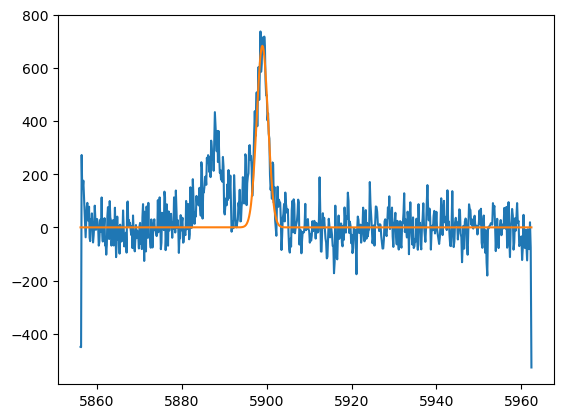

In [17]:
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.plot(v.energy, Peaks.gaussian(v.energy,*xes.popt))
#plt.xlim(6395,6410)

5899.013139102833 3.1017960818375423


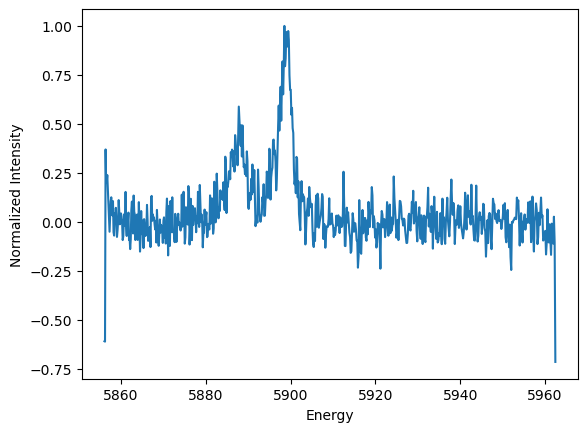

In [19]:
#First moment calculated after maximum peak normalized to 1
v.normalize_peak(fwhm_range[0],fwhm_range[1])
xes.first_moment=Peaks.first_moment(v.energy,v.normalized_peak,fwhm_range[0],fwhm_range[1])
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.normalized_peak,fwhm_range[0],fwhm_range[1])
plt.plot(v.energy,v.normalized_peak)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
print(xes.first_moment,xes.fwhm)

Text(0, 0.5, 'Normalized Intensity')

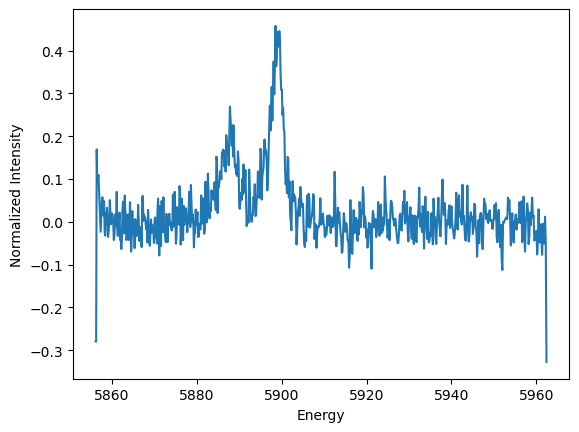

In [20]:
#Normalizes spectrum to make the area under in specified range equal to unity
v.normalize_spectrum(fwhm_range[0],fwhm_range[1])
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

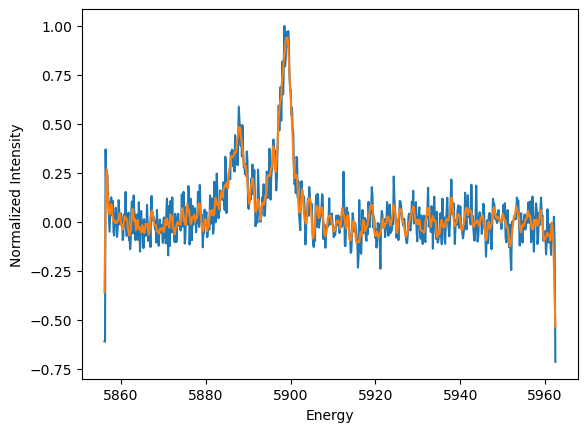

In [21]:
v.smoothed = signal.savgol_filter(v.normalized_peak, window_length=10, polyorder=2, mode="nearest")
plt.plot(v.energy,v.normalized_peak)
plt.plot(v.energy,v.smoothed)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

#Pickles data and analysis files based on above code
with open(f'Mn_data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'Mn_analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [22]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()

First Moment: 5899.013139102833
FWHM: 3.1017960818375423
Run Number: 665
  Total: 4426
  X-ray Total: 4426
  Laser Total: 4426
  XES_Hits: 1112
  Percent_XES_Hits: 25.12%

Run Number: 666
  Total: 8996
  X-ray Total: 8996
  Laser Total: 8996
  XES_Hits: 4878
  Percent_XES_Hits: 54.22%

Run Number: 667
  Total: 1816
  X-ray Total: 1816
  Laser Total: 1816
  XES_Hits: 1215
  Percent_XES_Hits: 66.91%



# Hopefully the hit rate is comparable to the other detector/signal's hit rate